# SSA (pca-like) dimensionality reduction of LANL data (toy example)

**Assumption**: the acoustic waveform data is very sparse. Therefore, we play with the SSA transform to hopely get a dense data manifold; we aim to feed the most representative SSA coefficients to the model, instead of the full continuous waveform.  

Please refer to this [kernel](https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition) for a comprehensive introduction to SSA. All credit to [pymssa package](https://github.com/kieferk/pymssa).

# Load packages

Clone multivariate SSA python repo.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
sns.set_style('whitegrid')

from pymssa import MSSA

/opt/conda/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


# Read 20k train rows

We read just 20k rows, since SVD matrix decomposition is very memory hungry.

In [2]:
# Read 20k rows and keep only acoustic data
df = pd.read_csv("../input/train.csv", nrows=20000, dtype={'acoustic_data': np.int16, 
                                                           'time_to_failure': np.float64})[['acoustic_data']]
# Zero-center data
df['acoustic_data'] -= df['acoustic_data'].mean()
df.head(5)

,acoustic_data
0,6.9503
1,0.9503
2,2.9503
3,-0.0497
4,2.9503


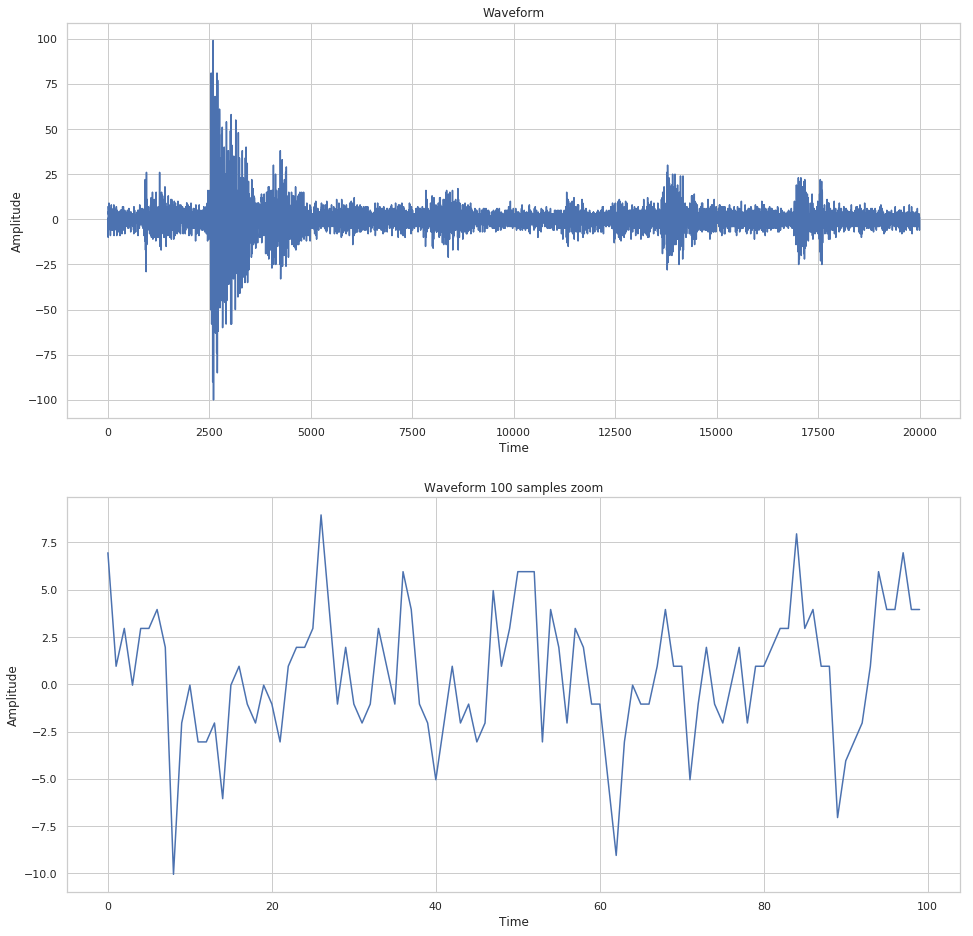

In [3]:
FIGSIZE = (16, 16)

fig, ax = plt.subplots(2, 1, figsize=FIGSIZE)
g = sns.lineplot(x=df.index[::2], y=df['acoustic_data'][::2], ax=ax[0])
ax[0].ticklabel_format(useOffset=False)
ax[0].set_title('Waveform');
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
g = sns.lineplot(x=df.index[:100], y=df['acoustic_data'][:100], ax=ax[1])
ax[1].ticklabel_format(useOffset=False)
ax[1].set_title('Waveform 100 samples zoom');
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Amplitude')
plt.show()

# Fit SSA transform

Fit SSA transform using only 16 components and a window size of 4096 samples ([recording data bins](https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/77526)).

In [4]:
N_COMPONENTS = 16
mssa = MSSA(n_components=N_COMPONENTS, window_size=4096, verbose=True)

In [ ]:
mssa.fit(df)

Constructing trajectory matrix
Trajectory matrix shape: (4096, 15905)
Decomposing trajectory covariance matrix with SVD


# Plot reconstruction

Plot waveform, each SSA component and the cumulative sum of the components.

### 20k samples reconstruction

In [ ]:
waveform = df['acoustic_data'].values
cumulative_recon = np.zeros_like(waveform)

for comp in range(N_COMPONENTS):  
    fig, ax = plt.subplots(figsize=(18, 7))
    current_component = mssa.components_[0, :, comp]
    cumulative_recon = cumulative_recon + current_component
    
    ax.plot(df.index, waveform, lw=3, alpha=0.2, c='k', label='waveform')
    ax.plot(df.index, cumulative_recon, lw=3, c='darkgoldenrod', alpha=0.6, label='cumulative'.format(comp))
    ax.plot(df.index, current_component, lw=3, c='steelblue', alpha=0.8, label='component={}'.format(comp))
    
    ax.legend()
    plt.show()

### 100 first samples reconstruction

In [ ]:
waveform = df['acoustic_data'].values[:100]
cumulative_recon = np.zeros_like(waveform)

for comp in range(N_COMPONENTS):  
    fig, ax = plt.subplots(figsize=(18, 7))
    current_component = mssa.components_[0, :100, comp]
    cumulative_recon = cumulative_recon + current_component
    
    ax.plot(df.index[:100], waveform, lw=3, alpha=0.2, c='k', label='Waveform 100 samples zoom')
    ax.plot(df.index[:100], cumulative_recon, lw=3, c='darkgoldenrod', alpha=0.6, label='cumulative'.format(comp))
    ax.plot(df.index[:100], current_component, lw=3, c='steelblue', alpha=0.8, label='component={}'.format(comp))
    
    ax.legend()
    plt.show()

# Conclusions

Despite not being a perfect fit (well using only 16 coeff), SSA is quite effective for reducing the dimensionality of the waveform data (int16 continuous values) in a few coefficients. However, we need a lighter SVD decomposition to fit the whole dataset, we think that it can be done by using an online method, such as [Incremental PCA](https://scikit-learn.org/stable/auto_examples/decomposition/plot_incremental_pca.html).

Nontheless, we don't know if this is the way to go... Is it worth to implement the online approach for the SSA package? What do kagglers think?